# Exploring Additional Clustering Models

## Imports/Flags

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

OUTPUT_CSV = False

In [85]:
merged_df = pd.read_pickle("../Datasets/merged_dataset")

In [3]:
merged_df.head()

,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,PCT_LACCESS_POP15,LACCESS_LOWI10,LACCESS_LOWI15,PCH_LACCESS_LOWI_10_15,PCT_LACCESS_LOWI10,PCT_LACCESS_LOWI15,...,PCH_SNAPS_12_16,SNAPSPTH12,SNAPSPTH16,PCH_SNAPSPTH_12_16,WICS08,WICS12,PCH_WICS_08_12,WICSPTH08,WICSPTH12,PCH_WICSPTH_08_12
0,18428.439685,17496.693038,-5.056026,33.769657,32.062255,5344.427472,6543.676824,22.439248,9.793530,11.991125,...,12.694878,0.674004,0.760911,12.894172,6,5,-16.66667,0.119156,0.090067,-24.412460
1,35210.814078,30561.264430,-13.204891,19.318473,16.767489,9952.144027,9886.831137,-0.656270,5.460261,5.424427,...,43.192771,0.725055,0.949753,30.990390,25,27,8.00000,0.141875,0.141517,-0.252126
2,5722.305602,6069.523628,6.067799,20.840972,22.105560,3135.676086,2948.790251,-5.959985,11.420316,10.739667,...,0.956938,1.280590,1.354387,5.762745,6,7,16.66667,0.201099,0.257344,27.968330
3,1044.867327,969.378841,-7.224696,4.559753,4.230324,491.449066,596.162829,21.307144,2.144661,2.601627,...,20.512821,0.719122,0.864874,20.267995,6,5,-16.66667,0.277919,0.221268,-20.383970
4,1548.175559,3724.428242,140.568857,2.700840,6.497380,609.027708,1650.959482,171.081177,1.062468,2.880150,...,23.903509,0.657144,0.815946,24.165470,10,6,-40.00000,0.173028,0.103760,-40.033200


## Scale

In [4]:
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(merged_df)

## Mean Shift

The mean shift algorithm is a heirarchical model, which means it builds on clusters, level by level. It is similar to kmeans, but instead of moving a centroid point, it shifts a window of predetermined size (either set by the user or an optimization fuction). 

In [5]:
mshift_data = pd.DataFrame(data_rescaled.copy())

In [6]:
mshift = MeanShift().fit(mshift_data)

In [7]:
clusters = mshift.predict(mshift_data)

In [8]:
pca = PCA(n_components = 2)
plotting_data = pd.DataFrame(pca.fit_transform(mshift_data))
plotting_data["clusters"] = clusters

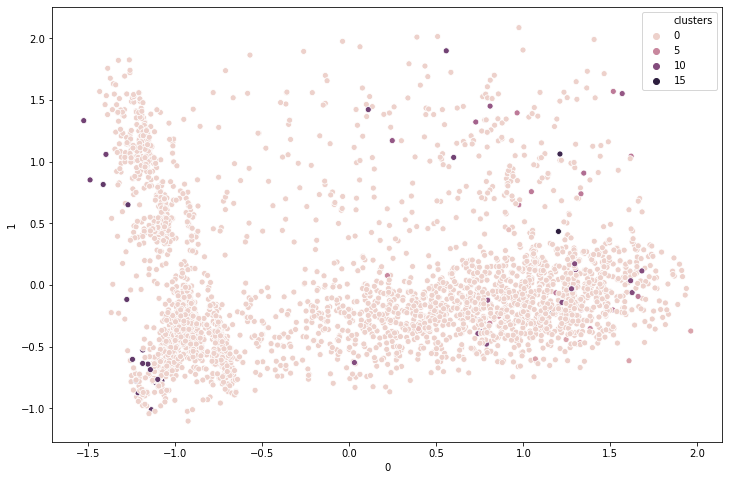

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.scatterplot(data=plotting_data,
                    x=0,
                    y=1,
                    hue="clusters")

When using PCA to view the multidimentional clustering, it is easy to see that kmeans is actually a better "out of the box" fit. Because of the shape of the groups on the left and the bottom, I am going to move on to a version of the gaussian algorithm. If that does not have a better immediate fit, I will move back to kmeans and focus on feature selection.  

## Gaussian Mixture Model

In [10]:
gmm = GaussianMixture(n_components=4, random_state=2)
clusters = gmm.fit_predict(data_rescaled)

In [11]:
pca = PCA(n_components = 2)
gmm_plot = pd.DataFrame(pca.fit_transform(data_rescaled))
gmm_plot["clusters"] = clusters

In [12]:
gmm.n_iter_

16

In [13]:
gmm.converged_

True

In [14]:
gmm.weights_

array([0.37523451, 0.10541411, 0.44259978, 0.07675159])

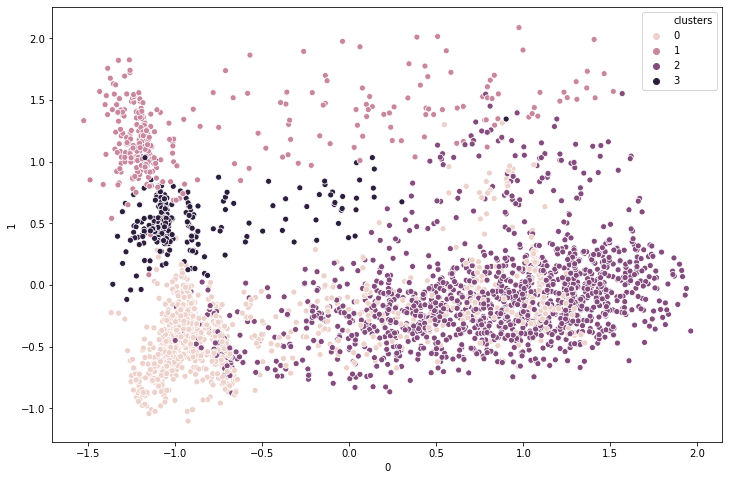

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.scatterplot(data=gmm_plot,
                    x=0,
                    y=1,
                    hue="clusters")

I think so far this is a great fit for the model. Although it is on a 177D plane, with PCA we are able to see how it looks with the two largest variance factors. Next I will test to see if a covariance type of `diag` instead of the default `full` will impact the model visually.

In [16]:
gmm = GaussianMixture(n_components=4, covariance_type="diag", random_state=2)
clusters = gmm.fit_predict(data_rescaled)

In [17]:
pca = PCA(n_components = 2)
gmm_plot = pd.DataFrame(pca.fit_transform(data_rescaled))
gmm_plot["clusters"] = clusters

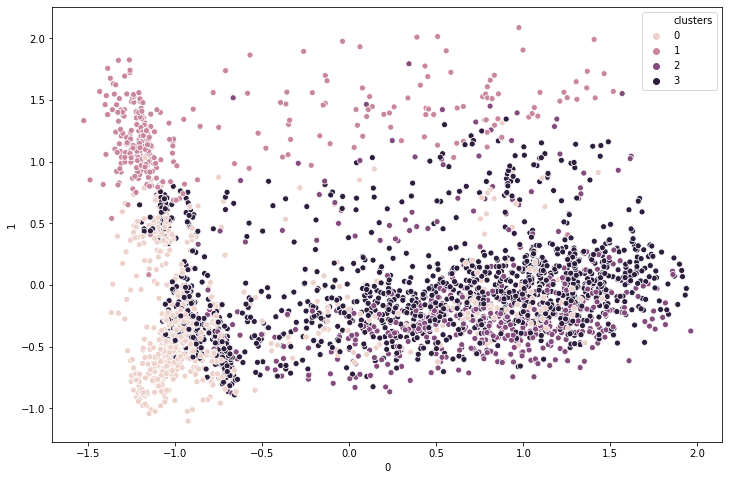

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.scatterplot(data=gmm_plot,
                    x=0,
                    y=1,
                    hue="clusters")

### Using PCA Data to fit model

In [21]:
pca = PCA(n_components = 0.99)
pca_data = pd.DataFrame(pca.fit_transform(data_rescaled))

In [22]:
pca_data.shape

(3140, 78)

In [23]:
gmm = GaussianMixture(n_components=4, random_state=2)
clusters = gmm.fit_predict(pca_data)

In [24]:
pca_data["clusters"] = clusters

In [25]:
pca_data["clusters"].value_counts()

3    1325
0     737
2     676
1     402
Name: clusters, dtype: int64

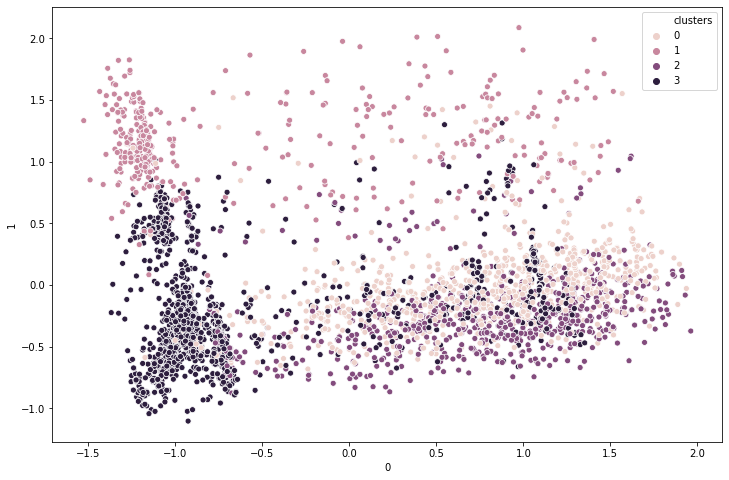

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.scatterplot(data=pca_data,
                    x=0,
                    y=1,
                    hue="clusters")

Although this clustering method is not the most exact - since it is on a 75 dimensional plane, I think it is a relatively good fit. However, I do think that the full model (177 variables) is a better fit visually. Next I will briefly explore a use case, then go into looking at the numerical effectiveness of the clustering with the silhouette score.

## Exploring a use-case

In [27]:
local = pd.read_pickle("../Datasets/local")

In [28]:
local["clusters"] = clusters

In [29]:
local.columns

Index(['FIPS', 'State', 'County', 'DIRSALES_FARMS07', 'DIRSALES_FARMS12',
       'PCH_DIRSALES_FARMS_07_12', 'PCT_LOCLFARM07', 'PCT_LOCLFARM12',
       'PCT_LOCLSALE07', 'PCT_LOCLSALE12', 'DIRSALES07', 'DIRSALES12',
       'PCH_DIRSALES_07_12', 'PC_DIRSALES07', 'PC_DIRSALES12',
       'PCH_PC_DIRSALES_07_12', 'FMRKT09', 'FMRKT16', 'PCH_FMRKT_09_16',
       'FMRKTPTH09', 'FMRKTPTH16', 'PCH_FMRKTPTH_09_16', 'FMRKT_SNAP16',
       'PCT_FMRKT_SNAP16', 'FMRKT_WIC16', 'PCT_FMRKT_WIC16', 'FMRKT_WICCASH16',
       'PCT_FMRKT_WICCASH16', 'FMRKT_SFMNP16', 'PCT_FMRKT_SFMNP16',
       'FMRKT_CREDIT16', 'PCT_FMRKT_CREDIT16', 'FMRKT_FRVEG16',
       'PCT_FMRKT_FRVEG16', 'FMRKT_ANMLPROD16', 'PCT_FMRKT_ANMLPROD16',
       'FMRKT_BAKED16', 'PCT_FMRKT_BAKED16', 'FMRKT_OTHERFOOD16',
       'PCT_FMRKT_OTHERFOOD16', 'FOODHUB16', 'CSA07', 'CSA12', 'PCH_CSA_07_12',
       'clusters'],
      dtype='object')

In [30]:
pd.set_option('display.max_columns', 400)

In [34]:
local_1 = local.loc[(local["clusters"] == 1)].copy()

In [35]:
local_1.loc[local_1["PCH_FMRKT_09_16"]==local_1["PCH_FMRKT_09_16"].max()]

,FIPS,State,County,DIRSALES_FARMS07,DIRSALES_FARMS12,PCH_DIRSALES_FARMS_07_12,PCT_LOCLFARM07,PCT_LOCLFARM12,PCT_LOCLSALE07,PCT_LOCLSALE12,DIRSALES07,DIRSALES12,PCH_DIRSALES_07_12,PC_DIRSALES07,PC_DIRSALES12,PCH_PC_DIRSALES_07_12,FMRKT09,FMRKT16,PCH_FMRKT_09_16,FMRKTPTH09,FMRKTPTH16,PCH_FMRKTPTH_09_16,FMRKT_SNAP16,PCT_FMRKT_SNAP16,FMRKT_WIC16,PCT_FMRKT_WIC16,FMRKT_WICCASH16,PCT_FMRKT_WICCASH16,FMRKT_SFMNP16,PCT_FMRKT_SFMNP16,FMRKT_CREDIT16,PCT_FMRKT_CREDIT16,FMRKT_FRVEG16,PCT_FMRKT_FRVEG16,FMRKT_ANMLPROD16,PCT_FMRKT_ANMLPROD16,FMRKT_BAKED16,PCT_FMRKT_BAKED16,FMRKT_OTHERFOOD16,PCT_FMRKT_OTHERFOOD16,FOODHUB16,CSA07,CSA12,PCH_CSA_07_12,clusters
390,13009,GA,Baldwin,14.0,7.0,-50.000000,8.235294,5.645161,0.838223,4.951299,50.0,61.0,22.000000,1.056279,1.313014,24.305652,0.0,4,400.0,0.0,0.088605,8.860535,1.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,100.0,2.0,50.0,2.0,50.0,2.0,50.0,2.0,50.0,0,0.0,4.0,400.0,1
1493,29023,MO,Butler,18.0,33.0,83.333333,2.965404,6.483301,0.111659,0.119530,100.0,151.0,51.000000,2.374789,3.511873,47.881457,0.0,4,400.0,0.0,0.093591,9.359133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,50.0,3.0,75.0,1.0,25.0,2.0,50.0,2.0,50.0,0,0.0,5.0,500.0,1
2107,39131,OH,Pike,40.0,41.0,2.500000,7.434944,8.367347,2.503551,1.112393,282.0,299.0,6.028369,9.844650,10.494910,6.605217,0.0,4,400.0,0.0,0.142045,14.204545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,100.0,4.0,100.0,4.0,100.0,4.0,100.0,4.0,100.0,0,6.0,6.0,0.0,1


It is interesting to see a possible use case for this clustering. A county official wants to drastically increse the number of farmers markets in their county. They look up their county, which is in cluster 1, and look for other counties that have significantly increase their number of farmers markets from 09-16. They can then look up these counties and see what policy decisions they have made.

## Clustering performance

### Silhouette Score

I will first do the silhouette score with the full dataset to see the optimal number of clusters. 

In [36]:
sil90 = []
K = range(2,40)
for k in K:
    gmm = GaussianMixture(n_components=k, random_state=2).fit(data_rescaled)
    labels = gmm.predict(data_rescaled)
    sil90.append(silhouette_score(data_rescaled, labels, metric = 'euclidean'))

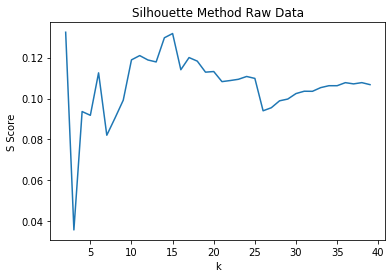

In [37]:
plt.plot(K, sil90)
plt.xlabel('k')
plt.ylabel('S Score')
plt.title('Silhouette Method Raw Data')
plt.show()

In [44]:
sil90

[0.13243464161409044,
 0.03570990786038486,
 0.09363372986369813,
 0.09178544606407246,
 0.11256614473201096,
 0.08204615970351539,
 0.09046247709193675,
 0.0991938790394826,
 0.11891465084498379,
 0.12101240431578893,
 0.11886233415965984,
 0.11790371776111187,
 0.129726692746458,
 0.13180998463792382,
 0.11409267586404241,
 0.12004673454735532,
 0.1182978407863043,
 0.11290155360164464,
 0.11321156366285176,
 0.10826967847449515,
 0.10880113800773561,
 0.10941320654421743,
 0.11079033480282867,
 0.10984650235052276,
 0.09400074286180769,
 0.09549708187604854,
 0.09887996997728996,
 0.09974355730071632,
 0.10242810177218525,
 0.10357119857303576,
 0.10353099824581907,
 0.10533624915617897,
 0.10627280789122817,
 0.10627090621830589,
 0.10776427842523895,
 0.10716523093581146,
 0.10777875238688597,
 0.10679444324276424]

Looking at the silhouette values, the true peak is at 2. However, that is not very helpful when it comes to using this to narrow down the number of couties to compare to. The difference between 2 clusters and 14 clusters is 0.0006. I think this level of accuracy is a good trade off to have something a bit more effective. Although the S score is extremely low (the goal being close to 1), this could still be a good starting point for counties with low budgets looking for resources. Another reason that the silhouette score would be lower would be because the clusters are not extremely dense (which the sihlouette is best suited for).

In [45]:
round(sil90[0]-sil90[13], 4)

0.0006

### Plotting 16 cluster model

In [60]:
gmm = GaussianMixture(n_components=14, random_state=2)
clusters = gmm.fit_predict(data_rescaled)
pca = PCA(n_components = 2)
gmm_plot = pd.DataFrame(pca.fit_transform(data_rescaled))
gmm_plot["clusters"] = clusters+1

In [73]:
gmm_plot.to_csv("../Datasets/clustered_data/clusters.csv")

In [62]:
gmm_plot["clusters"].value_counts()

6     423
9     419
8     353
1     269
7     263
13    251
5     208
14    207
11    199
3     164
4     130
12    123
10     70
2      61
Name: clusters, dtype: int64

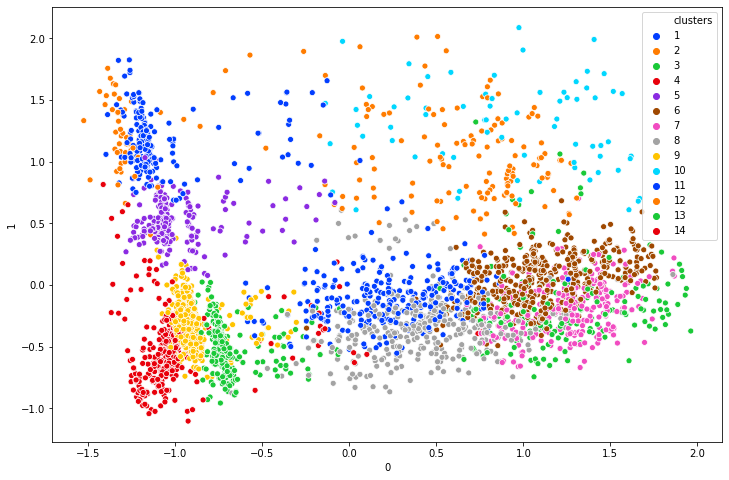

In [64]:
palette = sns.color_palette("bright", 14)
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.scatterplot(data=gmm_plot,
                    x=0,
                    y=1,
                    hue="clusters",
                    palette=palette,
                    legend="full")

## Exporting Clusters in CSV for Tableau

In [86]:
access = pd.read_pickle("../Datasets/access")
assistance = pd.read_pickle("../Datasets/assistance")
health = pd.read_pickle("../Datasets/health")
local = pd.read_pickle("../Datasets/local")
population = pd.read_pickle("../Datasets/population")
restaurants = pd.read_pickle("../Datasets/restaurants")
socioecnomic = pd.read_pickle("../Datasets/socioeconomic")
stores = pd.read_pickle("../Datasets/stores")

In [87]:
nonzero_cluster = clusters+1

In [88]:
merged_df["Clusters"] = nonzero_cluster
access["Clusters"] = nonzero_cluster
assistance["Clusters"] = nonzero_cluster
health["Clusters"] = nonzero_cluster
local["Clusters"] = nonzero_cluster
population["Clusters"] = nonzero_cluster
restaurants["Clusters"] = nonzero_cluster
socioecnomic["Clusters"] = nonzero_cluster
stores["Clusters"] = nonzero_cluster

In [89]:
merged_df = local[["FIPS","State","County"]].merge(merged_df, right_index=True, left_index=True)

In [90]:
merged_df.head()

,FIPS,State,County,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,PCT_LACCESS_POP15,LACCESS_LOWI10,LACCESS_LOWI15,PCH_LACCESS_LOWI_10_15,PCT_LACCESS_LOWI10,PCT_LACCESS_LOWI15,LACCESS_HHNV10,LACCESS_HHNV15,PCH_LACCESS_HHNV_10_15,PCT_LACCESS_HHNV10,PCT_LACCESS_HHNV15,LACCESS_SNAP15,PCT_LACCESS_SNAP15,LACCESS_CHILD10,LACCESS_CHILD15,LACCESS_CHILD_10_15,PCT_LACCESS_CHILD10,PCT_LACCESS_CHILD15,LACCESS_SENIORS10,LACCESS_SENIORS15,PCH_LACCESS_SENIORS_10_15,PCT_LACCESS_SENIORS10,PCT_LACCESS_SENIORS15,LACCESS_WHITE15,PCT_LACCESS_WHITE15,LACCESS_BLACK15,PCT_LACCESS_BLACK15,LACCESS_HISP15,PCT_LACCESS_HISP15,LACCESS_NHASIAN15,PCT_LACCESS_NHASIAN15,LACCESS_NHNA15,PCT_LACCESS_NHNA15,LACCESS_NHPI15,PCT_LACCESS_NHPI15,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15,REDEMP_SNAPS12,REDEMP_SNAPS16,PCH_REDEMP_SNAPS_12_16,PC_SNAPBEN10,PC_SNAPBEN15,PCH_PC_SNAPBEN_10_15,PCT_FREE_LUNCH09,PCT_FREE_LUNCH14,PCT_REDUCED_LUNCH09,PCT_REDUCED_LUNCH14,FDPIR12,PCT_DIABETES_ADULTS08,PCT_DIABETES_ADULTS13,PCT_OBESE_ADULTS08,PCT_OBESE_ADULTS13,RECFAC09,RECFAC14,PCH_RECFAC_09_14,RECFACPTH09,RECFACPTH14,PCH_RECFACPTH_09_14,DIRSALES_FARMS07,DIRSALES_FARMS12,PCH_DIRSALES_FARMS_07_12,PCT_LOCLFARM07,PCT_LOCLFARM12,PCT_LOCLSALE07,PCT_LOCLSALE12,DIRSALES07,DIRSALES12,PCH_DIRSALES_07_12,PC_DIRSALES07,PC_DIRSALES12,PCH_PC_DIRSALES_07_12,FMRKT09,FMRKT16,PCH_FMRKT_09_16,FMRKTPTH09,FMRKTPTH16,PCH_FMRKTPTH_09_16,FMRKT_SNAP16,PCT_FMRKT_SNAP16,FMRKT_WIC16,PCT_FMRKT_WIC16,FMRKT_WICCASH16,PCT_FMRKT_WICCASH16,FMRKT_SFMNP16,PCT_FMRKT_SFMNP16,FMRKT_CREDIT16,PCT_FMRKT_CREDIT16,FMRKT_FRVEG16,PCT_FMRKT_FRVEG16,FMRKT_ANMLPROD16,PCT_FMRKT_ANMLPROD16,FMRKT_BAKED16,PCT_FMRKT_BAKED16,FMRKT_OTHERFOOD16,PCT_FMRKT_OTHERFOOD16,FOODHUB16,CSA07,CSA12,PCH_CSA_07_12,2010 Census Population,"Population Estimate, 2011","Population Estimate, 2012","Population Estimate, 2013","Population Estimate, 2014","Population Estimate, 2015","Population Estimate, 2016",FFR09,FFR14,PCH_FFR_09_14,FFRPTH09,FFRPTH14,PCH_FFRPTH_09_14,FSR09,FSR14,PCH_FSR_09_14,FSRPTH09,FSRPTH14,PCH_FSRPTH_09_14,PC_FFRSALES07,PC_FFRSALES12,PC_FSRSALES07,PC_FSRSALES12,PCT_NHWHITE10,PCT_NHBLACK10,PCT_HISP10,PCT_NHASIAN10,PCT_NHNA10,PCT_NHPI10,PCT_65OLDER10,PCT_18YOUNGER10,MEDHHINC15,POVRATE15,PERPOV10,CHILDPOVRATE15,PERCHLDPOV10,METRO13,POPLOSS10,GROC09,GROC14,PCH_GROC_09_14,GROCPTH09,GROCPTH14,PCH_GROCPTH_09_14,SUPERC09,SUPERC14,PCH_SUPERC_09_14,SUPERCPTH09,SUPERCPTH14,PCH_SUPERCPTH_09_14,CONVS09,CONVS14,PCH_CONVS_09_14,CONVSPTH09,CONVSPTH14,PCH_CONVSPTH_09_14,SPECS09,SPECS14,PCH_SPECS_09_14,SPECSPTH09,SPECSPTH14,PCH_SPECSPTH_09_14,SNAPS12,SNAPS16,PCH_SNAPS_12_16,SNAPSPTH12,SNAPSPTH16,PCH_SNAPSPTH_12_16,WICS08,WICS12,PCH_WICS_08_12,WICSPTH08,WICSPTH12,PCH_WICSPTH_08_12,Clusters
0,1001,AL,Autauga,18428.439685,17496.693038,-5.056026,33.769657,32.062255,5344.427472,6543.676824,22.439248,9.793530,11.991125,664.216487,677.672769,2.025888,3.284786,3.351332,931.935186,4.608749,4822.500269,4616.971480,-4.261872,8.837112,8.460485,2388.233228,2180.809285,-8.685247,4.376378,3.996279,12640.615414,23.163613,4216.473194,7.726582,471.136164,0.863345,86.767975,0.159000,61.169869,0.112092,8.817961,0.016159,482.848633,0.884808,301432.081069,239024.015573,-20.703856,16.692321,17.905272,7.266521,32.006749,0.000000,8.217547,0.000000,0,11.4,13.0,31.5,34.1,4,5,25.000000,0.073889,0.090261,22.156783,25.0,51.0,104.000000,6.024096,13.110540,0.596374,1.554692,100.0,308.0,208.000000,1.908215,5.582238,192.537200,2.0,1,-50.0,0.039404,0.018045,-54.204562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,1.0,100.0,1.0,100.0,0,2.0,3.0,50.000000,54571,55255,55027,54792,54977,55035,55416,30,36,20.000000,0.554170,0.649878,17.270512,34,29,-14.705882,0.628059,0.523513,-16.645960,649.511367,674.80272,484.381507,512.280987,77.246156,17.582599,2.400542,0.855766,0.397647,0.040314,11.995382,26.777959,56580.0,12.7,0,18.8,0,1,0.0,6,4,-33.333333,0.110834,0.072209,-34.849716,1,1,0.0,0.018472,0.018052,-2.274574,29,30,3.448276,0.535698,0.541565,1.095269,2,2,0.000000,0.

In [70]:
merged_df["Clusters"].value_counts()

6     423
9     419
8     353
1     269
7     263
13    251
5     208
14    207
11    199
3     164
4     130
12    123
10     70
2      61
Name: Clusters, dtype: int64

In [91]:
if OUTPUT_CSV:
    print("creating CSVs")
    merged_df.to_csv("../Datasets/clustered_data/dataset_clusters.csv")
    stores.to_csv("../Datasets/clustered_data/stores_clusters.csv")
    access.to_csv("../Datasets/clustered_data/access_clusters.csv")
    population.to_csv("../Datasets/clustered_data/population_clusters.csv")
    restaurants.to_csv("../Datasets/clustered_data/restaurants_clusters.csv")
    assistance.to_csv("../Datasets/clustered_data/assistance_clusters.csv")
    local.to_csv("../Datasets/clustered_data/local_clusters.csv")
    health.to_csv("../Datasets/clustered_data/health_clusters.csv")
    socioecnomic.to_csv("../Datasets/clustered_data/socioeconomic_clusters.csv")
else:
    print("no output")

creating CSVs
